
The purpose of this file is to impute values for budget based on a round robin regression on all features of the dataset.
---
Source:
https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html


In [8]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
import csv
import numpy as np
from math import exp
import ast
from sklearn.ensemble import RandomForestRegressor

In [9]:
# Initialize csv file paths
csv_file_path= 'final_train_dataset_with_categorical.csv'
# Create DataFrames from both CSV files
df = pd.read_csv(csv_file_path)

In [10]:
# Assuming 'df' is your existing dataframe
df['Merged Budget'] = df['Merged Budget'].replace(100000, np.nan)

selected_columns = [
    'IMDB Budget', 'TMDB Budget', 'TMDB Revenue', 'Runtime', 'IMDB Domestic Revenue',
    'international_revenue', 'worldwide_revenue', 'Merged Budget', 'Merged Revenue',
    'Release Year', 'Unweighted Star Score', 'Simple Weight Star Score',
    'Log Weight Star Score', 'Exponential Weight Star Score',
    'Movie Contribution to Director and Production Scores', 'Total Director Score',
    'Avg Director Score', 'Total Production Company Score',
    'Avg Production Company Score', 'Genre Cluster', 'Domestic Distributor ID',
    'Domestic Distributor Score', 'G', 'NC-17', 'NR', 'PG', 'PG-13', 'R',
    'Adj Merged Budget', 'Adj Merged Revenue', 'Has Star Score',
    'Has Director Score', 'Has Production Company Score',
    'Has Domestic Distributor Score', 'Unweighted Star Score_normalized',
    'Simple Weight Star Score_normalized', 'Log Weight Star Score_normalized',
    'Exponential Weight Star Score_normalized', 'Total Director Score_normalized',
    'Avg Director Score_normalized', 'Total Production Company Score_normalized',
    'Avg Production Company Score_normalized', 'Domestic Distributor Score_normalized'
]
fit_df = df[selected_columns]
# Remove rows where 'Merged Budget' is NaN
fit_df = fit_df.dropna(subset=['Merged Budget'])

# Create a new dataframe with selected columns, skipping the first row
new_df = df[selected_columns]
# Replace values equal to 100000 in the 'Merged Budget' column with empty values

# Display the updated dataframe
new_df.head()  # Use .head() to display the first few rows for verification


IMDB Budget  TMDB Budget  TMDB Revenue  Runtime  IMDB Domestic Revenue  \
0            0            0             0       83                   2241   
1     35000000     56000000      34737199      109               19701164   
2            0            0             0       90                 134049   
3            0            0       1553826      106                1561962   
4            0      7000000        257019       89                 257019   

   international_revenue  worldwide_revenue  Merged Budget  Merged Revenue  \
0                   2241                NaN            NaN            2241   
1               15036035         34737199.0     35000000.0        19701164   
2                 134049                NaN            NaN          134049   
3                1561962                NaN            NaN         1561962   
4                 257019                NaN      7000000.0          257019   

   Release Year  ...  Has Domestic Distributor Score  \
0          2013  ...                               0   
1          2013  ...                               1   
2          2013  ...                               0   
3          2013  ...                               0   
4          2013  ...                               0   

   Unweighted Star Score_normalized  Simple Weight Star Score_normalized  \
0                         -1.197882                            -0.834900   
1                          1.625458                             1.909947   
2                         -1.223715                            -0.523574   
3                         -0.308416                            -0.624991   
4                         -1.750039                            -1.391208   

   Log Weight Star Score_normalized  Exponential Weight Star Score_normalized  \
0                         -1.914023                                 -1.492851   
1                          2.052669                                  2.116033   
2                         -0.754037                                 -0.503238   
3                         -0.869441                                 -0.118806   
4                         -1.057694                                 -0.869858   

   Total Director Score_normalized  Avg Director Score_normalized  \
0                         0.020794                       0.140460   
1                         1.517545                       1.537691   
2                         0.323499                       0.158286   
3                        -0.179807                      -1.146126   
4                         1.010863                      -1.911306   

   Total Production Company Score_normalized  \
0                                  -1.351097   
1                                   0.698288   
2                                  -0.666598   
3                                  -0.893549   
4                                   0.509202   

   Avg Production Company Score_normalized  \
0                                -0.771759   
1                                 0.449979   
2                                -0.458559   
3                                -1.395688   
4                                 0.694398   

   Domestic Distributor Score_normalized  
0                              -0.075203  
1                               1.123415  
2                              -0.887904  
3                              -0.991378  
4                              -0.914777  

[5 rows x 43 columns]

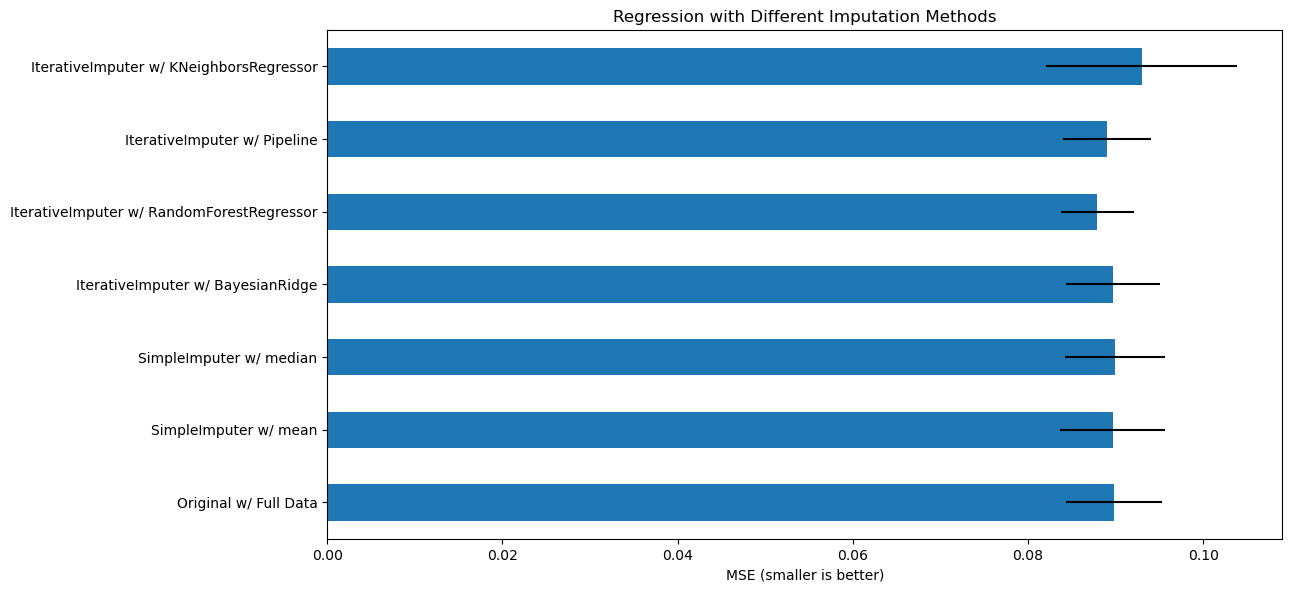

In [13]:
# DO NOT run this cell unless you are testing estimators
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

N_SPLITS = 5

# Assuming 'fit_df' is your existing DataFrame

# Dummy y values for the sake of the example
y_values = np.random.random(size=len(fit_df))

# Replace NaNs in the DataFrame with numpy NaNs
fit_df.replace('', np.nan, inplace=True)

fit_df = fit_df.iloc[:1000]  # Taking the first 1000 samples for training
y_values = y_values[:1000]

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
fit_df = imputer.fit_transform(fit_df)

n_samples, n_features = fit_df.shape

# Estimate the score on the entire dataset, with no missing values
br_estimator = BayesianRidge()
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, fit_df, y_values, scoring="neg_mean_squared_error", cv=N_SPLITS
    ),
    columns=["Full Data"],
)

# Add a single missing value to each row
fit_df_missing = fit_df.copy()
missing_samples = np.arange(n_samples)
missing_features = np.random.choice(n_features, n_samples, replace=True)
fit_df_missing[missing_samples, missing_features] = np.nan

# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ("mean", "median"):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy), br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, fit_df_missing, y_values, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    RandomForestRegressor(n_estimators=4, max_depth=10, random_state=0),
    make_pipeline(Nystroem(kernel="polynomial", degree=2, random_state=0), Ridge(alpha=1e3)),
    KNeighborsRegressor(n_neighbors=15),
]
score_iterative_imputer = pd.DataFrame()
tolerances = (1e-3, 1e-1, 1e-1, 1e-2)
for impute_estimator, tol in zip(estimators, tolerances):
    estimator = make_pipeline(
        IterativeImputer(
            random_state=0, estimator=impute_estimator, max_iter=25, tol=tol
        ),
        br_estimator,
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = cross_val_score(
        estimator, fit_df_missing, y_values, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=["Original", "SimpleImputer", "IterativeImputer"],
    axis=1,
)

# plot results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title("Regression with Different Imputation Methods")
ax.set_xlabel("MSE (smaller is better)")
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()


In [12]:
imp = IterativeImputer(min_value=0, max_iter=100, random_state=1, estimator=RandomForestRegressor())
imp.fit(fit_df)
IterativeImputer(random_state=1)
imp_df = imp.transform(new_df)
imp_df = pd.DataFrame(imp_df, columns=new_df.columns)
imp_df.head()

IMDB Budget  TMDB Budget  TMDB Revenue  Runtime  IMDB Domestic Revenue  \
0          0.0          0.0           0.0     83.0                 2241.0   
1   35000000.0   56000000.0    34737199.0    109.0             19701164.0   
2          0.0          0.0           0.0     90.0               134049.0   
3          0.0          0.0     1553826.0    106.0              1561962.0   
4          0.0    7000000.0      257019.0     89.0               257019.0   

   international_revenue  worldwide_revenue  Merged Budget  Merged Revenue  \
0                 2241.0           43054.84      172839.31          2241.0   
1             15036035.0        34737199.00    35000000.00      19701164.0   
2               134049.0          221093.19      174316.79        134049.0   
3              1561962.0         2767720.44      175316.79       1561962.0   
4               257019.0          510761.25     7000000.00        257019.0   

   Release Year  ...  Has Domestic Distributor Score  \
0        2013.0  ...                             0.0   
1        2013.0  ...                             1.0   
2        2013.0  ...                             0.0   
3        2013.0  ...                             0.0   
4        2013.0  ...                             0.0   

   Unweighted Star Score_normalized  Simple Weight Star Score_normalized  \
0                         -1.197882                            -0.834900   
1                          1.625458                             1.909947   
2                         -1.223715                            -0.523574   
3                         -0.308416                            -0.624991   
4                         -1.750039                            -1.391208   

   Log Weight Star Score_normalized  Exponential Weight Star Score_normalized  \
0                         -1.914023                                 -1.492851   
1                          2.052669                                  2.116033   
2                         -0.754037                                 -0.503238   
3                         -0.869441                                 -0.118806   
4                         -1.057694                                 -0.869858   

   Total Director Score_normalized  Avg Director Score_normalized  \
0                         0.020794                       0.140460   
1                         1.517545                       1.537691   
2                         0.323499                       0.158286   
3                        -0.179807                      -1.146126   
4                         1.010863                      -1.911306   

   Total Production Company Score_normalized  \
0                                  -1.351097   
1                                   0.698288   
2                                  -0.666598   
3                                  -0.893549   
4                                   0.509202   

   Avg Production Company Score_normalized  \
0                                -0.771759   
1                                 0.449979   
2                                -0.458559   
3                                -1.395688   
4                                 0.694398   

   Domestic Distributor Score_normalized  
0                              -0.075203  
1                               1.123415  
2                              -0.887904  
3                              -0.991378  
4                              -0.914777  

[5 rows x 43 columns]

In [14]:
fin_df = pd.read_csv(csv_file_path)

# Selecting only the 'Merged Budget' column from imp_df
imp_df_merged_budget = imp_df[['Merged Budget']]

# Replace 'Merged Budget' column in 'fin_df' with the values from 'imp_df_merged_budget'
fin_df['Merged Budget'] = imp_df_merged_budget['Merged Budget']
imp_df.head()
# Save the modified DataFrame 'fin_df' as a CSV file

# Uncomment the next line to save
fin_df.to_csv('imputed_budget.csv', index=False)